# temp nn

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
%load_ext autoreload
%autoreload 1
%aimport tiny_nn

from tiny_nn import Module, Tensor, Linear
from tiny_nn import MSELoss, MAELoss, SGD
from tiny_nn import ReLU, Sigmoid, Tanh
from tiny_nn import Sequential
from tiny_nn import generate_lj_data, lennard_jones_potential

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
fulldata = np.loadtxt("dists-energies/combineddata.dat")


In [4]:
fulldata.shape

(120035, 2)

In [16]:
r_train, V_train = generate_lj_data(n_samples=2000, noise=0.02)
r_test, V_test = generate_lj_data(n_samples=500, r_min=0.9, r_max=2.8, noise=0.0)

print(f"Training data shape: {r_train.shape} -> {V_train.shape}")
print(f"Test data shape: {r_test.shape} -> {V_test.shape}")


Training data shape: (2000, 1) -> (2000, 1)
Test data shape: (500, 1) -> (500, 1)


In [33]:

# Create neural network
print("\nBuilding neural network...")
model = Sequential(
    Linear(1, 32),  # Input layer: 1D distance -> 32 neurons
    Tanh(),  # Activation
    Linear(32, 64),  # Hidden layer: 32 -> 64 neurons
    ReLU(),  # Activation
    Linear(64, 32),  # Hidden layer: 64 -> 32 neurons
    Tanh(),  # Activation
    Linear(32, 1),  # Output layer: 32 -> 1 (potential energy)
)

model = Sequential(
    Linear(1, 4),  # Input layer: 1D distance -> 32 neurons
    Sigmoid(),  # Activation
    Linear(4, 4),  # Hidden layer: 32 -> 64 neurons
    Sigmoid(),  # Activation
    Linear(4, 1),  # Output layer: 32 -> 1 (potential energy)
)

# Initialize optimizer and loss function
optimizer = SGD(model.params, lr=0.001)
criterion = MSELoss()

print(f"Model has {len(model.params)} parameter tensors and {model.num_params} total parameters.")


Building neural network...
Model has 6 parameter tensors and 33 total parameters.


In [29]:
# Training loop
print("\nStarting training...")
n_epochs = 10000
batch_size = 64
n_batches = len(r_train) // batch_size

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0.0

    # Shuffle data
    indices = np.random.permutation(len(r_train))
    r_shuffled = r_train[indices]
    V_shuffled = V_train[indices]

    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size

        # Get batch
        r_batch = r_shuffled[start_idx:end_idx]
        V_batch = V_shuffled[start_idx:end_idx]

        # Forward pass
        optimizer.zero_grad()
        V_pred = model.forward(r_batch)
        loss = criterion.forward(V_pred, V_batch)

        # Backward pass
        grad_loss = criterion.backward()
        model.backward(grad_loss)

        # Update parameters
        optimizer.step()
        epoch_loss += loss

    # Record average loss for this epoch
    avg_loss = epoch_loss / n_batches
    optimizer.record_loss(avg_loss)

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.6f}")

print("Training completed!")


Starting training...
Epoch 100/10000, Loss: 23.549665
Epoch 200/10000, Loss: 22.848918
Epoch 300/10000, Loss: 23.012156
Epoch 400/10000, Loss: 23.277200
Epoch 500/10000, Loss: 22.761549
Epoch 600/10000, Loss: 21.354923
Epoch 700/10000, Loss: 18.990432
Epoch 800/10000, Loss: 15.920117
Epoch 900/10000, Loss: 12.380940
Epoch 1000/10000, Loss: 9.893309
Epoch 1100/10000, Loss: 7.653493
Epoch 1200/10000, Loss: 5.956278
Epoch 1300/10000, Loss: 4.684760
Epoch 1400/10000, Loss: 3.722558
Epoch 1500/10000, Loss: 2.992924
Epoch 1600/10000, Loss: 2.412982
Epoch 1700/10000, Loss: 1.983417
Epoch 1800/10000, Loss: 1.635070
Epoch 1900/10000, Loss: 1.364783
Epoch 2000/10000, Loss: 1.160574
Epoch 2100/10000, Loss: 0.944432
Epoch 2200/10000, Loss: 0.862912
Epoch 2300/10000, Loss: 0.752034
Epoch 2400/10000, Loss: 0.667167
Epoch 2500/10000, Loss: 0.594936
Epoch 2600/10000, Loss: 0.535559
Epoch 2700/10000, Loss: 0.485863
Epoch 2800/10000, Loss: 0.448063
Epoch 2900/10000, Loss: 0.416383
Epoch 3000/10000, Los


Evaluating on test set...
Test Loss (MSE): 0.002612
Test Loss (MAE): 0.029543

Generating visualizations...


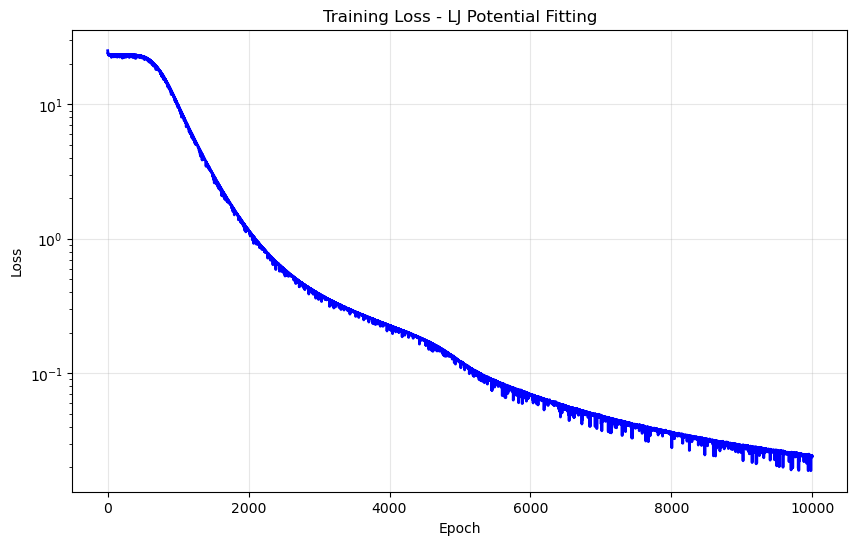

In [30]:

# Evaluate on test set
print("\nEvaluating on test set...")
model.eval()
V_test_pred = model.forward(r_test)
test_loss = criterion.forward(V_test_pred, V_test)
print(f"Test Loss (MSE): {test_loss:.6f}")

# Calculate test MAE for comparison
mae_criterion = MAELoss()
test_mae = mae_criterion.forward(V_test_pred, V_test)
print(f"Test Loss (MAE): {test_mae:.6f}")

# Visualize results
print("\nGenerating visualizations...")

# Plot training loss
optimizer.visualize("Training Loss - LJ Potential Fitting")

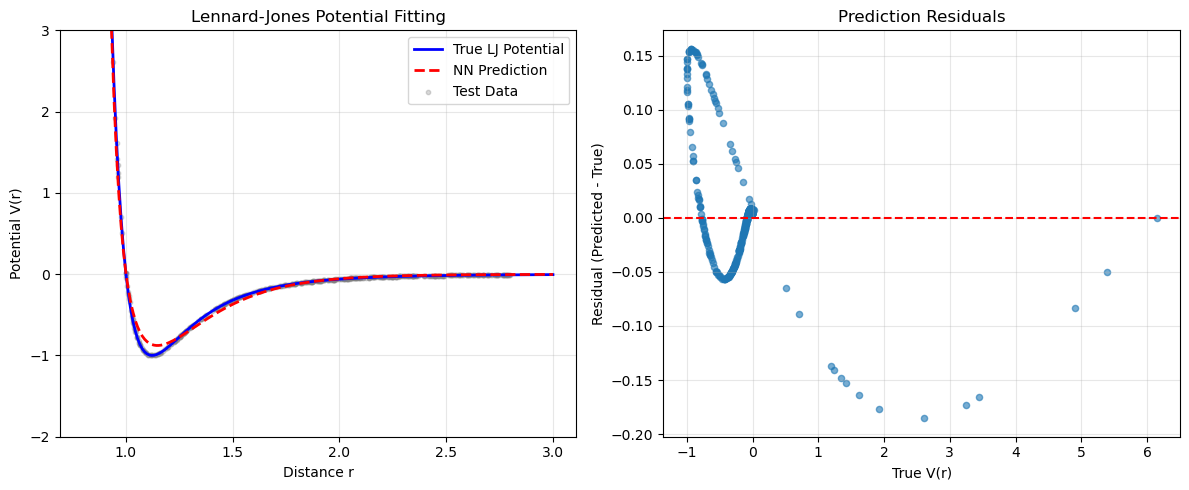

In [31]:
# Plot LJ potential fit
r_plot = np.linspace(0.8, 3.0, 200).reshape(-1, 1)
V_true = lennard_jones_potential(r_plot)
V_pred_plot = model.forward(r_plot)

plt.figure(figsize=(12, 5))

# Plot potential comparison
plt.subplot(1, 2, 1)
plt.plot(r_plot.flatten(), V_true.flatten(), "b-", label="True LJ Potential", linewidth=2)
plt.plot(r_plot.flatten(), V_pred_plot.flatten(), "r--", label="NN Prediction", linewidth=2)
plt.scatter(r_test.flatten(), V_test.flatten(), alpha=0.3, s=10, c="gray", label="Test Data")
plt.xlabel("Distance r")
plt.ylabel("Potential V(r)")
plt.title("Lennard-Jones Potential Fitting")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-2, 3)

# Plot residuals
plt.subplot(1, 2, 2)
residuals = V_test_pred.flatten() - V_test.flatten()
plt.scatter(V_test.flatten(), residuals, alpha=0.6, s=20)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("True V(r)")
plt.ylabel("Residual (Predicted - True)")
plt.title("Prediction Residuals")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

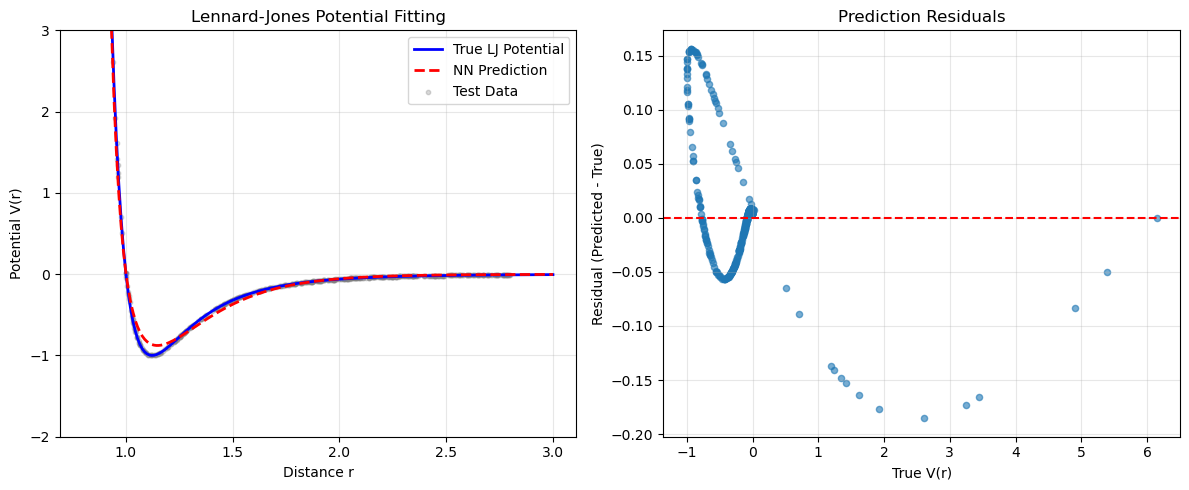


Testing model save/load functionality...
Model saved to lj_model.pkl
Model loaded from lj_model.pkl
Difference between original and loaded model: 0.2716758693

Tutorial completed successfully!


In [32]:


# Plot LJ potential fit
r_plot = np.linspace(0.8, 3.0, 200).reshape(-1, 1)
V_true = lennard_jones_potential(r_plot)
V_pred_plot = model.forward(r_plot)

plt.figure(figsize=(12, 5))

# Plot potential comparison
plt.subplot(1, 2, 1)
plt.plot(r_plot.flatten(), V_true.flatten(), "b-", label="True LJ Potential", linewidth=2)
plt.plot(r_plot.flatten(), V_pred_plot.flatten(), "r--", label="NN Prediction", linewidth=2)
plt.scatter(r_test.flatten(), V_test.flatten(), alpha=0.3, s=10, c="gray", label="Test Data")
plt.xlabel("Distance r")
plt.ylabel("Potential V(r)")
plt.title("Lennard-Jones Potential Fitting")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-2, 3)

# Plot residuals
plt.subplot(1, 2, 2)
residuals = V_test_pred.flatten() - V_test.flatten()
plt.scatter(V_test.flatten(), residuals, alpha=0.6, s=20)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("True V(r)")
plt.ylabel("Residual (Predicted - True)")
plt.title("Prediction Residuals")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test model saving and loading
print("\nTesting model save/load functionality...")
model.save("lj_model.pkl")

# Create a new model and load weights
model_loaded = Sequential(Linear(1, 32), Tanh(), Linear(32, 64), ReLU(), Linear(64, 32), Tanh(), Linear(32, 1))
model_loaded.load("lj_model.pkl")

# Test that loaded model gives same predictions
V_loaded_pred = model_loaded.forward(r_test)
diff = np.mean(np.abs(V_loaded_pred - V_test_pred))
print(f"Difference between original and loaded model: {diff:.10f}")

print("\nTutorial completed successfully!")
